In [66]:
import os
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
import keras 
import tensorflow as tf
from keras.models import Sequential 
from tensorflow.keras.optimizers import Adam 
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense 
from sklearn.utils import shuffle 
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa 
import cv2
import pandas as pd 
import ntpath 
import random

In [67]:
# Load Train Data

datadir = "data"
columns = ["center", "left", "right", "steering", "throttle", "reverse", "speed"]
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names=columns)
pd.set_option('display.max_colwidth', -1)
data.head()

C:\Users\YSH\AppData\Local\Temp/ipykernel_12796/1581048176.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


center  ...     speed
0  C:\Users\YSH\Documents\OurAICar\simulation\simple\data\IMG\center_2022_02_22_12_44_40_526.jpg  ...  5.951196
1  C:\Users\YSH\Documents\OurAICar\simulation\simple\data\IMG\center_2022_02_22_12_44_40_598.jpg  ...  5.903379
2  C:\Users\YSH\Documents\OurAICar\simulation\simple\data\IMG\center_2022_02_22_12_44_40_670.jpg  ...  5.855948
3  C:\Users\YSH\Documents\OurAICar\simulation\simple\data\IMG\center_2022_02_22_12_44_40_737.jpg  ...  5.820624
4  C:\Users\YSH\Documents\OurAICar\simulation\simple\data\IMG\center_2022_02_22_12_44_40_809.jpg  ...  5.785095

[5 rows x 7 columns]

## Image Path Edit

Split the src of the image to load image appropriate.

In [68]:
def path_leaf(path): 
    head, tail = ntpath.split(path)
    return tail

In [17]:
print(path_leaf('C:/Users/YSH/Documents/OurAICar/simulation/simple/data/IMG/center_2022_02_22_12_44_40_809.jpg'))

C:/Users/YSH/Documents/OurAICar/simulation/simple/data/IMG center_2022_02_22_12_44_40_809.jpg
('C:/Users/YSH/Documents/OurAICar/simulation/simple/data/IMG', 'center_2022_02_22_12_44_40_809.jpg')


In [69]:
data["center"] = data["center"].apply(path_leaf)
data["left"] = data["left"].apply(path_leaf)
data["right"] = data["right"].apply(path_leaf)
data.head()

center  ...     speed
0  center_2022_02_22_12_44_40_526.jpg  ...  5.951196
1  center_2022_02_22_12_44_40_598.jpg  ...  5.903379
2  center_2022_02_22_12_44_40_670.jpg  ...  5.855948
3  center_2022_02_22_12_44_40_737.jpg  ...  5.820624
4  center_2022_02_22_12_44_40_809.jpg  ...  5.785095

[5 rows x 7 columns]

## Train Data Optimization

Data distribution is distorted and we have to optimize it

In [70]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data["steering"], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5

total data: 3005


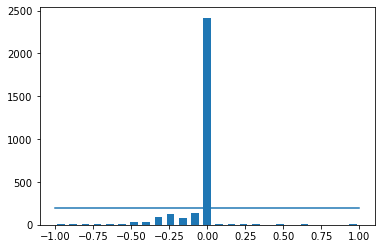

In [71]:
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data["steering"]), np.max(data["steering"])), (samples_per_bin, samples_per_bin))
print(f"total data: {len(data)}")

In [72]:
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data["steering"])):
        if data["steering"][i] >= bins[j] and data["steering"][i] <= bins[j+1]:
            list_.append(i)
            
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

In [73]:
print(f"removed: {len(remove_list)}")
data.drop(data.index[remove_list], inplace=True)
print(f"remaining: {len(data)}")

removed: 2217
remaining: 788


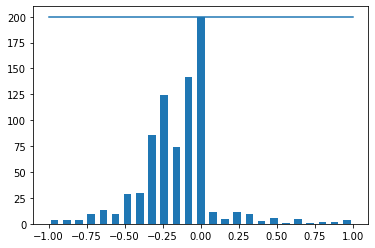

In [74]:
hist, _ = np.histogram(data["steering"], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data["steering"]), np.max(data["steering"])), (samples_per_bin, samples_per_bin))

In [75]:
print(data.iloc[1])

center      center_2022_02_22_12_44_40_879.jpg
left        left_2022_02_22_12_44_40_879.jpg  
right       right_2022_02_22_12_44_40_879.jpg 
steering   -0.25                              
throttle    0.0                               
reverse     0                                 
speed       5.726951                          
Name: 5, dtype: object


## Load Image

Loading Image and Augment it to extend dataset.

In [76]:
# Load Center, Left, Right Image and Steering data 
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir,center.strip()))
        steering.append(float(indexed_data[3]))
        
        # Left image append 
        image_path.append(os.path.join(datadir,left.strip()))
        steering.append(float(indexed_data[3]) + 0.15)
    
        # Right image append 
        image_path.append(os.path.join(datadir,right.strip()))
        steering.append(float(indexed_data[3] - 0.15))
        
        
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings


In [77]:
image_paths, steerings = load_img_steering(datadir + '/IMG', data)
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print(f'Training Samples: {len(X_train)}\nValid Samples: {len(X_valid)}')

Training Samples: 1891
Valid Samples: 473


Text(0.5, 1.0, 'Validation set')

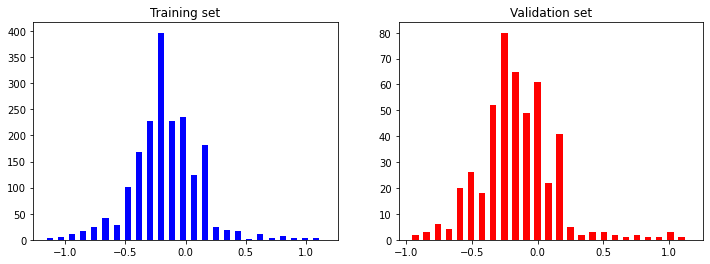

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [79]:
# Image Augment - zoom
def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

Text(0.5, 1.0, 'Zoomed Image')

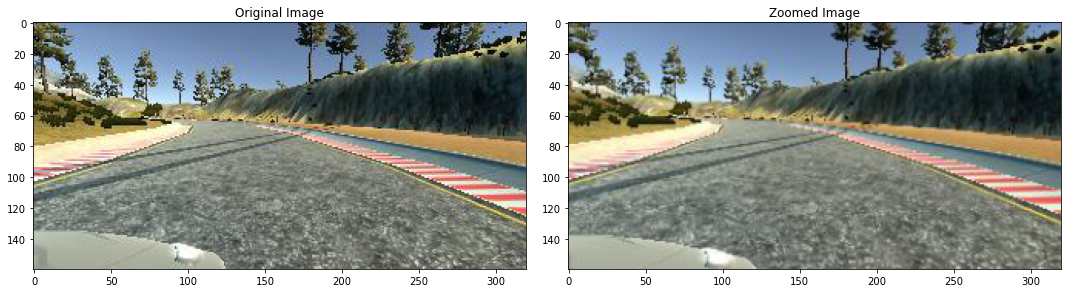

In [80]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title("Original Image")
axs[1].imshow(zoomed_image)
axs[1].set_title("Zoomed Image")

In [81]:
# Image Augment - pan
def pan(image):
    pan = iaa.Affine(translate_percent={"x":(-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

Text(0.5, 1.0, 'Panned Image')

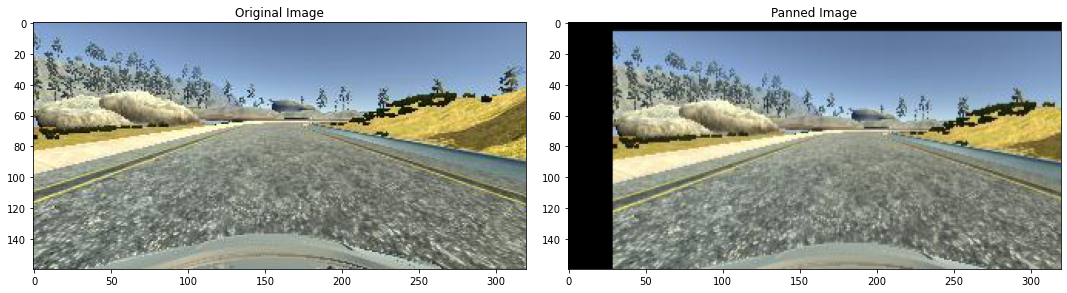

In [82]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

In [83]:
# Image Augment - Brightness
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

Text(0.5, 1.0, 'Brightness altered image ')

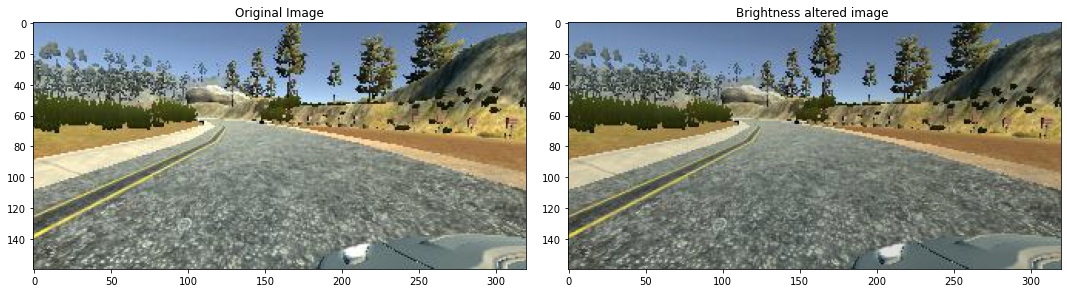

In [84]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

In [85]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

In [86]:
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

Text(0.5, 1.0, 'Flipped Image - Steering Angle:0.05000000000000002')

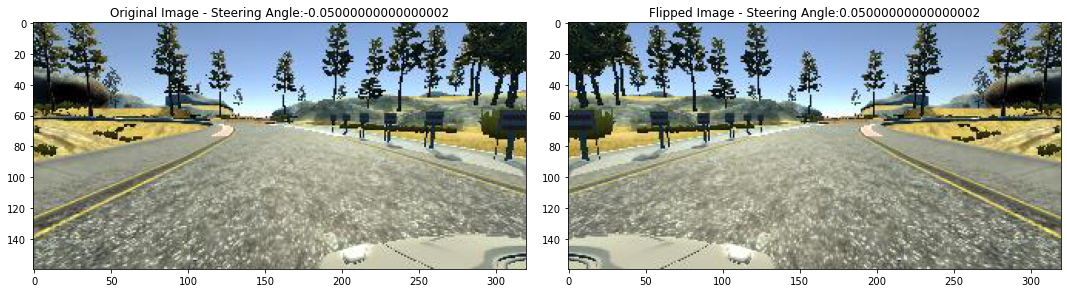

In [87]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))
 
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [88]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle

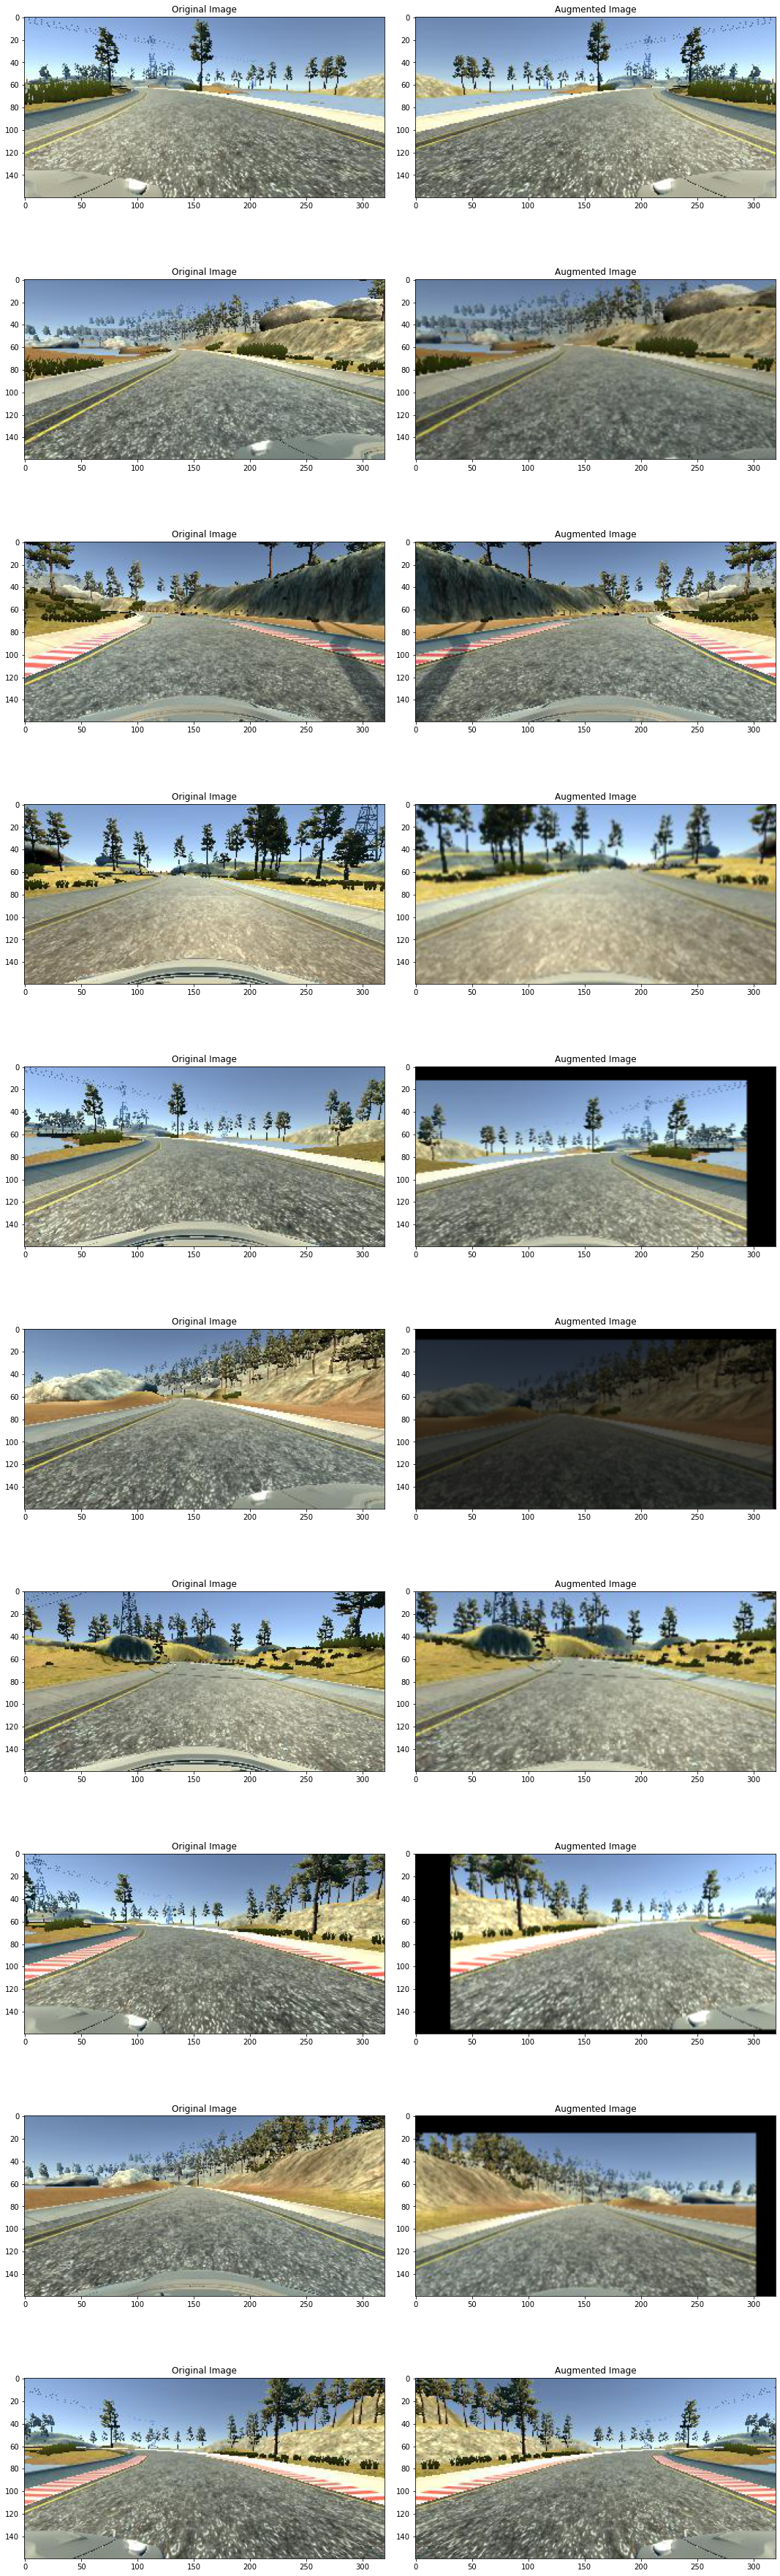

In [89]:
ncol = 2
nrow = 10
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

In [90]:
# PreProcess Image
def img_preprocess(img):
    img = img[60:135, :, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img / 255 
    return img

In [91]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

Text(0.5, 1.0, 'Preprocessed Image')

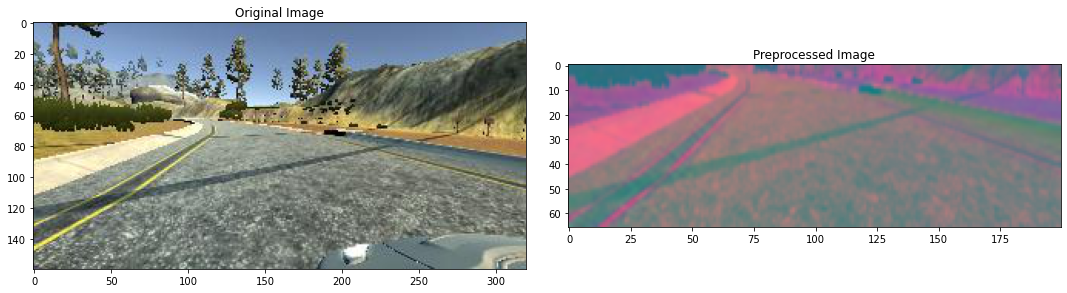

In [92]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [93]:
# batch generator
def batch_generator(image_paths, steering_ang, batch_size, istraining):
      
  while True:
    batch_img = []
    batch_steering = []
    
    for _ in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))  

In [94]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

Text(0.5, 1.0, 'Validation Image')

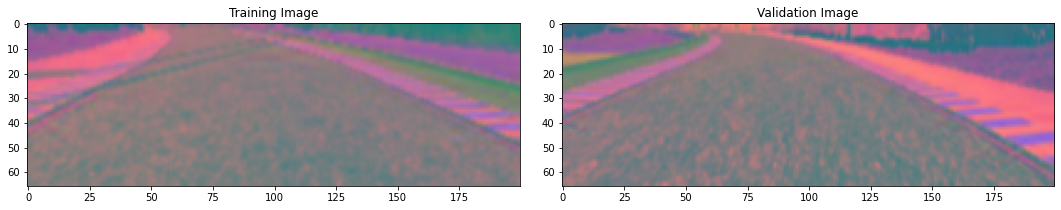

In [95]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [96]:
def nvidia_model():
    model = Sequential()
    model.add(Conv2D(24, kernel_size=(5, 5), strides=(2,2), input_shape=(66, 200, 3), activation="relu"))
    model.add(Conv2D(36, kernel_size=(5, 5), strides=(2,2), activation="relu"))
    model.add(Conv2D(48, kernel_size=(5, 5), strides=(2,2), activation="relu"))
    model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
    model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(100, activation="relu"))
    model.add(Dropout(0.5))
    
    model.add(Dense(50, activation="relu"))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate=1e-3)

    model.compile(loss="mse", optimizer=optimizer)
    model.summary()
    return model

In [97]:
model = nvidia_model()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_12 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_13 (Conv2D)          (None, 3, 20, 64)         27712     
                                                                 
 conv2d_14 (Conv2D)          (None, 1, 18, 64)         36928     
                                                                 
 dropout_4 (Dropout)         (None, 1, 18, 64)         0         
                                                                 
 flatten_2 (Flatten)         (None, 1152)             

In [98]:
model.build(input_shape=(None, 66, 200, 3))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_12 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_13 (Conv2D)          (None, 3, 20, 64)         27712     
                                                                 
 conv2d_14 (Conv2D)          (None, 1, 18, 64)         36928     
                                                                 
 dropout_4 (Dropout)         (None, 1, 18, 64)         0         
                                                                 
 flatten_2 (Flatten)         (None, 1152)             

In [99]:
history = model.fit(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Epoch 1/10
300/300 [==============================] - 130s 433ms/step - loss: 0.0740 - val_loss: 0.0444
Epoch 2/10
300/300 [==============================] - 131s 437ms/step - loss: 0.0547 - val_loss: 0.0433
Epoch 3/10
300/300 [==============================] - 134s 448ms/step - loss: 0.0500 - val_loss: 0.0436
Epoch 4/10
300/300 [==============================] - 131s 437ms/step - loss: 0.0466 - val_loss: 0.0385
Epoch 5/10
300/300 [==============================] - 131s 437ms/step - loss: 0.0423 - val_loss: 0.0352
Epoch 6/10
300/300 [==============================] - 136s 455ms/step - loss: 0.0415 - val_loss: 0.0353
Epoch 7/10
300/300 [==============================] - 141s 470ms/step - loss: 0.0399 - val_loss: 0.0377
Epoch 8/10
300/300 [==============================] - 135s 452ms/step - loss: 0.0389 - val_loss: 0.0347
Epoch 9/10
300/300 [==============================] - 132s 441ms/step - loss: 0.0388 - val_loss: 0.0326
Epoch 10/10
300/300 [==============================] - 136s 453m

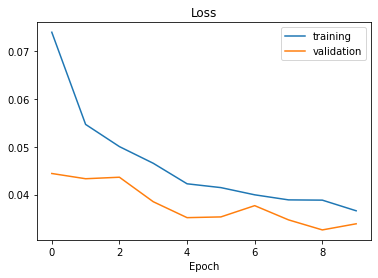

In [100]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')
model.save('model.h5')